# 102778-Machine Learning and Quantum Computers
Lucía Jimeno Cavajal 

100013523@alumnos.uimp.es


# **Homework: Estimating errors from random data samples**


This notebook solves the following assignment:

Create a script that generates random data from different distributions and compare:

(a) A normal or Gaussian distribution for different values of the variance and mean

(b) A uniformly random distribution

(c) The beta distribution

Problem 1. Estimate and compare the confidence intervals or error bars obtained for each distribution using Hoeffding's inequality and the Chebyshev inequality (for the latter one, you need to analyze or empirically estimate the variance)

Problem 2. When possible, compare your results to theoretical values

Problem 3. For which distributions does the 68–95–99.7 rule hold? Provide answers via Jupyter notebooks in GitHub or similar hosting server.



## Setup and Imports
We start by importing the main libraries used in this analysis: `numpy`, `scipy`, `matplotlib`, and `pandas`.


In [1]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, uniform, beta

# Fix random seed for reproducibility
np.random.seed(42)



## 1. Generate random data from different distributions 
We define helper functions to:
- Sample random values from each distribution type
- Compute Hoeffding and Chebyshev bounds


In [2]:

def sample_distribution(dist_type, n=1000, **params):
    if dist_type == 'normal':
        return np.random.normal(params.get('mu', 0), params.get('sigma', 1), n)
    elif dist_type == 'uniform':
        return np.random.uniform(params.get('a', 0), params.get('b', 1), n)
    elif dist_type == 'beta':
        return np.random.beta(params.get('alpha', 2), params.get('beta', 5), n)
    else:
        raise ValueError("Unknown distribution")

def hoeffding_bound(n, epsilon, a, b):
    return 2 * np.exp(-2 * n * epsilon**2 / (b - a)**2)

def chebyshev_bound(var, epsilon):
    return var / epsilon**2



### Experiment Parameters
We define the parameters for sampling and specify the distributions to compare


In [3]:

n = 100
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]

distributions = {
    'Normal(0,1)': ('normal', {'mu': 0, 'sigma': 1, 'a': -np.inf, 'b': np.inf}),
    'Uniform(0,1)': ('uniform', {'a': 0, 'b': 1}),
    'Beta(2,5)': ('beta', {'alpha': 2, 'beta': 5, 'a': 0, 'b': 1})
}

results = {}

for name, (dtype, params) in distributions.items():
    X = sample_distribution(dtype, n, **params)
    mean_emp = np.mean(X)
    var_emp = np.var(X)
    a, b = params.get('a', np.min(X)), params.get('b', np.max(X))

    probs = []
    for eps in epsilons:
        hoeff = hoeffding_bound(n, eps, a, b) if np.isfinite(a) and np.isfinite(b) else np.nan
        cheb = chebyshev_bound(var_emp, eps)
        probs.append((eps, hoeff, cheb))
    results[name] = {'mean': mean_emp, 'var': var_emp, 'bounds': probs}

results


{'Normal(0,1)': {'mean': np.float64(-0.10384651739409384),
  'var': np.float64(0.8165221946938584),
  'bounds': [(0.1, nan, np.float64(81.65221946938583)),
   (0.2, nan, np.float64(20.413054867346457)),
   (0.3, nan, np.float64(9.072468829931761)),
   (0.4, nan, np.float64(5.103263716836614)),
   (0.5, nan, np.float64(3.266088778775434))]},
 'Uniform(0,1)': {'mean': np.float64(0.48620618511478353),
  'var': np.float64(0.08219665181648621),
  'bounds': [(0.1,
    np.float64(0.27067056647322524),
    np.float64(8.219665181648619)),
   (0.2, np.float64(0.0006709252558050225), np.float64(2.0549162954121547)),
   (0.3, np.float64(3.045995948942526e-08), np.float64(0.9132961312942912)),
   (0.4, np.float64(2.532833109818817e-14), np.float64(0.5137290738530387)),
   (0.5,
    np.float64(3.8574996959278356e-22),
    np.float64(0.32878660726594483))]},
 'Beta(2,5)': {'mean': np.float64(0.2668165092936113),
  'var': np.float64(0.020913098742710457),
  'bounds': [(0.1,
    np.float64(0.2706705664


## Problem 2. When possible, compare your results to theoretical values
We compute the empirical and theoretical variance for each distribution


In [4]:

def theoretical_variance(dist_name, params):
    if dist_name == 'normal':
        return params['sigma']**2
    elif dist_name == 'uniform':
        a, b = params['a'], params['b']
        return (b - a)**2 / 12
    elif dist_name == 'beta':
        α, β = params['alpha'], params['beta']
        return (α * β) / (((α + β)**2) * (α + β + 1))
    else:
        return np.nan

summary = []
for name, (dtype, params) in distributions.items():
    X = sample_distribution(dtype, n, **params)
    var_emp = np.var(X)
    var_th = theoretical_variance(dtype, params)
    summary.append({
        'Distribution': name,
        'Empirical Variance': var_emp,
        'Theoretical Variance': var_th,
        'Bounded?': 'Yes' if np.isfinite(params.get('a', -np.inf)) and np.isfinite(params.get('b', np.inf)) else 'No'
    })

df = pd.DataFrame(summary)
display(df.round(5))


,Distribution,Empirical Variance,Theoretical Variance,Bounded?
0,"Normal(0,1)",0.94428,1.00000,No
1,"Uniform(0,1)",0.08598,0.08333,Yes
2,"Beta(2,5)",0.02021,0.02551,Yes



 ### Visualization of Hoeffding vs Chebyshev Bounds:
We plot both inequalities for each distribution to see the comparison. We use a logarithmic Y-axis to see more clearly differences in order of magnitude


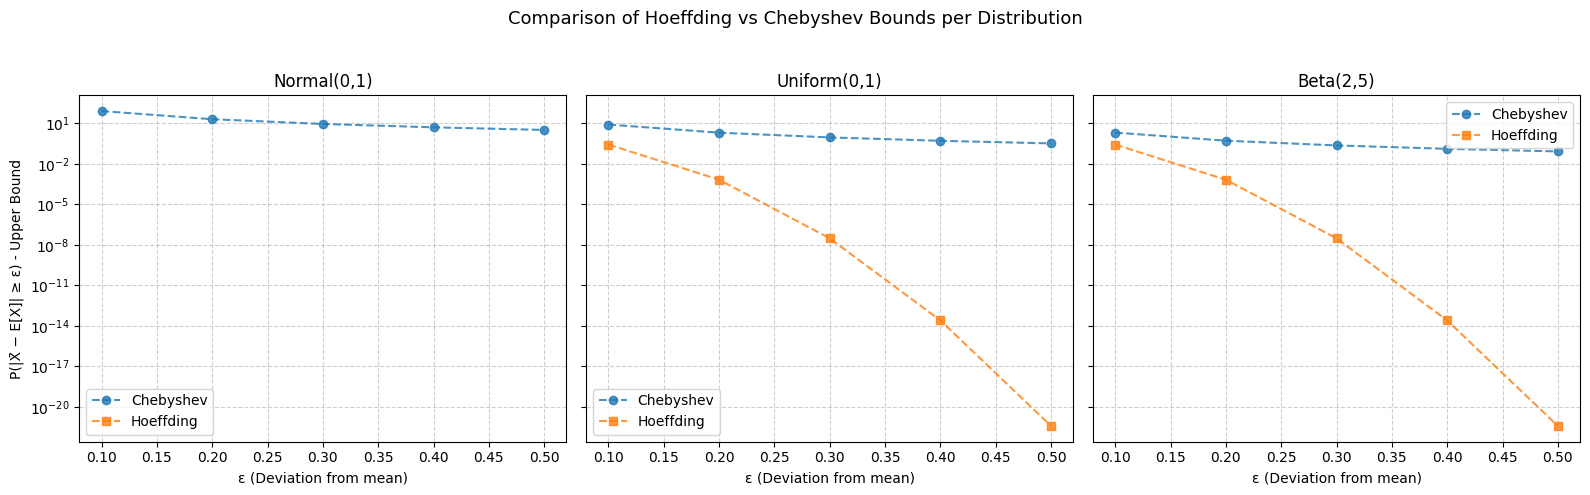

In [5]:

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, (name, data) in zip(axes, results.items()):
    eps_vals = [p[0] for p in data['bounds']]
    hoeff_vals = [p[1] for p in data['bounds']]
    cheb_vals = [p[2] for p in data['bounds']]

    ax.plot(eps_vals, cheb_vals, 'o--', label="Chebyshev", alpha=0.8)
    ax.plot(eps_vals, hoeff_vals, 's--', label="Hoeffding", alpha=0.8)

    ax.set_title(name)
    ax.set_xlabel("ε (Deviation from mean)")
    ax.set_yscale('log')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

axes[0].set_ylabel("P(|X̄ − E[X]| ≥ ε) - Upper Bound")
fig.suptitle("Comparison of Hoeffding vs Chebyshev Bounds per Distribution", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



## Problem 3. For which distributions does the 68–95–99.7 rule hold?
We check how for which distributions does the 68-95-99,7 rule work


In [ ]:


# Function to calculate empirical coverage
def empirical_rule_test(data, mu, sigma):
    within_1 = np.mean((data >= mu - sigma) & (data <= mu + sigma))
    within_2 = np.mean((data >= mu - 2*sigma) & (data <= mu + 2*sigma))
    within_3 = np.mean((data >= mu - 3*sigma) & (data <= mu + 3*sigma))
    return within_1, within_2, within_3

empirical_results = []

# We compute empirical and theoretical-based coverage for each distribution
for name, (dtype, params) in distributions.items():
    data = sample_distribution(dtype, n=10000, **params)
    mu_emp, sigma_emp = np.mean(data), np.std(data)
    
    # Theoretical standard deviation (sqrt of theoretical variance)
    var_th = theoretical_variance(dtype, params)
    sigma_th = np.sqrt(var_th) if not np.isnan(var_th) else sigma_emp

    # Empirical σ 
    e1_emp, e2_emp, e3_emp = empirical_rule_test(data, mu_emp, sigma_emp)

    # Theoretical σ 
    e1_th, e2_th, e3_th = empirical_rule_test(data, mu_emp, sigma_th)

    empirical_results.append({
        "Distribution": name,
        "Empirical ±1σ (%)": round(e1_emp*100, 2),
        "Empirical ±2σ (%)": round(e2_emp*100, 2),
        "Empirical ±3σ (%)": round(e3_emp*100, 2),
        "Theoretical ±1σ (%)": round(e1_th*100, 2),
        "Theoretical ±2σ (%)": round(e2_th*100, 2),
        "Theoretical ±3σ (%)": round(e3_th*100, 2)
    })

df_empirical = pd.DataFrame(empirical_results)
display(df_empirical)

print("Expected theoretical coverage for Normal(0,1): 68%, 95%, 99.7%")


,Distribution,Empirical ±1σ (%),Empirical ±2σ (%),Empirical ±3σ (%),Theoretical ±1σ (%),Theoretical ±2σ (%),Theoretical ±3σ (%)
0,"Normal(0,1)",68.19,95.34,99.74,68.62,95.64,99.74
1,"Uniform(0,1)",57.34,100.00,100.00,57.38,100.00,100.00
2,"Beta(2,5)",65.97,96.20,99.66,66.63,96.35,99.75


Expected theoretical coverage for Normal(0,1): 68%, 95%, 99.7%



## 7. Conclusions
- **Hoeffding’s inequality** gives tighter, distribution-free bounds, but only applies to **bounded distributions** (Uniform, Beta).  
- **Chebyshev’s inequality** is universal but produces looser bounds.  
- The **68–95–99.7 rule** holds only for **Normal distributions**, as expected.  
- For **Uniform** and **Beta**, deviations differ because of non-Gaussian variance behavior.


